In [11]:
import torch
import lightning.pytorch as pl
import matplotlib.pyplot as plt
from hydra.utils import instantiate

from icicl.utils.experiment_utils import extract_config
from icicl.data.on_off_grid import OOTGBatch, SyntheticOOTGGenerator
from icicl.data.gp import RandomScaleGPGenerator

%load_ext autoreload
%autoreload 2

# Trying OOTG Batches!

In [34]:
OOTGGen = SyntheticOOTGGenerator(
    off_grid_generator=RandomScaleGPGenerator(
        dim=1, 
        kernel_type= "eq", min_log10_lengthscale= -0.602, max_log10_lengthscale= 0.602, noise_std= 0.2,
        out_dim=2,
        min_num_ctx = 1, max_num_ctx = 64, min_num_trg = 128, max_num_trg = 128,
        context_range = [[-2.0, 2.0]],
        target_range = [[-3.0, 3.0]],
        samples_per_epoch = 16384,
        batch_size = 16
    ),
    grid_range=[[-3.0, 3.0]],
    points_per_unit=64,
    samples_per_epoch = 16000,
    batch_size = 16,
)

In [36]:
for batch in OOTGGen:
    print(batch.xc_on_grid.shape)
    print(batch.yc_on_grid.shape)
    print(batch.yc_off_grid.shape)
    print(batch.xt.shape)
    break

torch.Size([16, 513, 1])
torch.Size([16, 513, 1])
torch.Size([16, 12, 1])
torch.Size([16, 128, 1])


In [30]:
from icicl.models.ootg_tnp import OOTGSetConvEncoder
from icicl.utils.helpers import preprocess_observations
from icicl.utils.conv import flatten_grid, unflatten_grid
from icicl.networks.mlp import MLP
import einops

grid_encoder = OOTGSetConvEncoder(dim=1, init_lengthscale=2 * 1 / 4)
xy_encoder = MLP(in_dim= 3 + 1, out_dim = 5, num_layers = 2, width= 32)

patch_size = 4
conv = torch.nn.Conv1d(in_channels=5, out_channels=5, kernel_size=patch_size, stride=patch_size)

for batch in OOTGGen:
    xc, yc = grid_encoder(xc_off_grid=batch.xc_off_grid, yc_off_grid=batch.yc_off_grid, xc_on_grid=batch.xc_on_grid, yc_on_grid=batch.yc_on_grid)

    yc, yt = preprocess_observations(batch.xt, yc)
    zc = torch.cat((xc, yc), dim=-1)
    zc = xy_encoder(zc)
    print(zc.shape)

    zc = unflatten_grid(zc, dim=1)
    zc = zc.movedim(-1, 1)
    print(zc.shape)
    zc = conv(zc)
    print(zc.shape)
    zc = zc.movedim(1, -1)
    zc = flatten_grid(zc)
    print(zc.shape)

    zt = torch.cat((batch.xt, yt), dim=-1)
    zt = xy_encoder(zt)
    print(zt.shape)
    break

torch.Size([16, 33, 5])
torch.Size([16, 5, 33])
torch.Size([16, 5, 8])
torch.Size([16, 8, 5])
torch.Size([16, 128, 5])


# Profiling

In [77]:
#config, config_dict = extract_config("experiments/configs/thesis/ootg_gp_conv_encoder_tnp.yml", [])
config, config_dict = extract_config("experiments/configs/thesis/ootg_gp_conv_encoder_vit.yml", [])
pl.seed_everything(config.misc.seed)
experiment = instantiate(config)
pl.seed_everything(experiment.misc.seed)

Global seed set to 0
Global seed set to 0


0

In [85]:
from icicl.utils.experiment_utils import np_loss_fn
import time

model = experiment.model
gen_train = experiment.generators.train
grid_encoder = OOTGSetConvEncoder(dim=1, init_lengthscale=2 * 1 / 4)

start = time.time()
for i, batch in enumerate(gen_train):
    #grid_encoder(batch.xc_off_grid, batch.yc_off_grid, batch.xc_on_grid, batch.yc_on_grid)
    #np_loss_fn(model, batch)
    
    if i > 100:
        break

print(f"This took {time.time() - start} seconds")

This took 14.630586385726929 seconds


# ConvSet TNP Encoder Tests

In [2]:
from icicl.utils.conv import make_grid, flatten_grid, unflatten_grid
import torch 
import math
import einops

grid_range = torch.as_tensor([[-3.0, 3.0], [-4.0, 4.0]])
print(grid_range)

batch_shape = torch.Size((2,))


grid = make_grid(
    xmin = grid_range[:, 0].repeat(*batch_shape, 1), 
    xmax = grid_range[:, 1].repeat(*batch_shape, 1), 
    points_per_unit = 4, 
    margin = 0)

print(grid.shape)



plat = flatten_grid(grid)

onplat = unflatten_grid(plat)


torch.allclose(grid, onplat)


tensor([[-3.,  3.],
        [-4.,  4.]])
torch.Size([2, 33, 33, 2])


True

# Getting the true log-likelihood

In [1]:
from tqdm import tqdm
import lightning.pytorch as pl
from hydra.utils import instantiate
from experiments.plot import plot
from icicl.utils.experiment_utils import extract_config

config, config_dict = extract_config("experiments/configs/thesis/ootg_gp_conv_encoder_tnp.yml", [])
config["generators"]["val"]["samples_per_epoch"] = 16
config["generators"]["off_grid_generator_val"]["out_dim"] = 2 # TODO change
pl.seed_everything(config.misc.seed)
experiment = instantiate(config)
pl.seed_everything(experiment.misc.seed)

batches = []
for batch in tqdm(experiment.generators.val, total=len(experiment.generators.val), desc="Validation"):
        batches.append(batch)


%load_ext autoreload
%autoreload 2

/home/erl50/.conda/envs/tnp/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Global seed set to 0
Global seed set to 0
Validation: 100%|██████████| 1/1 [00:02<00:00,  2.24s/it]


In [2]:
print(batches[0].xc.shape, batches[0].yc.shape, batches[0].xt.shape, batches[0].yt.shape)

torch.Size([16, 302, 1]) torch.Size([16, 302, 1]) torch.Size([16, 128, 1]) torch.Size([16, 128, 1])


  0%|          | 0/500 [00:00<?, ?it/s]/home/erl50/.conda/envs/tnp/lib/python3.9/site-packages/torch/cuda/__init__.py:611: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")
100%|██████████| 500/500 [00:26<00:00, 19.15it/s]
/home/erl50/.conda/envs/tnp/lib/python3.9/site-packages/linear_operator/utils/interpolation.py:71: UserWarning: torch.sparse.SparseTensor(indices, values, shape, *, device=) is deprecated.  Please use torch.sparse_coo_tensor(indices, values, shape, dtype=, device=). (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:605.)
  summing_matrix = cls(summing_matrix_indices, summing_matrix_values, size)
100%|██████████| 500/500 [00:25<00:00, 19.51it/s]
/home/erl50/.conda/envs/tnp/lib/python3.9/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-08 to the diagonal
  warnings.warn(


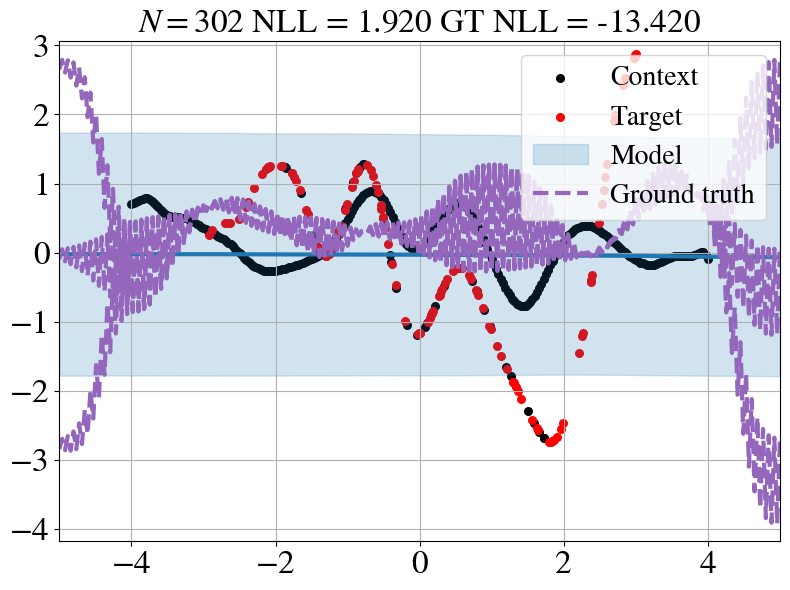

In [3]:
plot(model=experiment.model, batches=batches, num_fig=1)